# MNIST Prior Samples

In [5]:
import argparse
import os, sys
import time
import tabulate

import torch
import torch.nn.functional as F
import torchvision
import numpy as np
import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

from swag import data, models, utils, losses
from swag.posteriors import SWAG

%matplotlib inline

In [6]:
model_cfg = getattr(models, "LeNet5")

loaders, num_classes = data.loaders(
    "MNIST",
    "~/datasets/",
    10000,
    4,
    model_cfg.transform_train,
    model_cfg.transform_test,
    use_validation=False,
    split_classes=None,
    shuffle_train=False
)
loader = loaders["test"]

model = model_cfg.base(*model_cfg.args, num_classes=num_classes, **model_cfg.kwargs)
model.cuda();

You are going to run models on the test set. Are you sure?


In [7]:
def resample(model, sigma=1):
    for p in model.parameters():
        p.copy_(torch.randn_like(p) * sigma)
        
def softmax(arr, axis=-1):
    arr_ = arr - np.max(arr, axis=axis, keepdims=True)
    return np.exp(arr_) / np.sum(np.exp(arr_), axis=axis, keepdims=True)

## Preparing data

In [11]:
for x, y in loader:
    break
    
mask = np.zeros_like(y).astype(bool)
classes = [0,1]
perclass = 200

for cls in classes:
    mask_cls = np.where(y == cls)[0]
    mask[mask_cls[:perclass]] = True

x = x[mask].cuda()
y = y[mask]

idx = np.argsort(y)
x = x[idx]
y = y[idx]

In [12]:
x = x[[0, -1]].float()
d = (x[1] - x[0])[None, :]
x = x[0][None, :]

t = torch.linspace(-1, 2, 100)[:, None, None, None].cuda()
x = (x + t * d)

norms = x.norm(dim=(2,3))[:, 0]
x *= norms[0] / norms[:, None, None, None]

In [18]:
x.shape

torch.Size([100, 1, 28, 28])

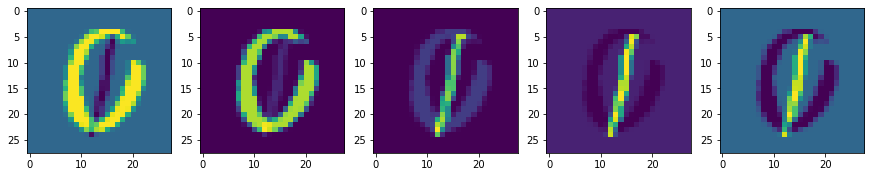

In [35]:
f, arr = plt.subplots(1, 5, figsize=(15, 5))
arr[0].imshow(x[0].data.cpu().numpy()[0])

arr[1].imshow(x[37].data.cpu().numpy()[0])
arr[2].imshow(x[50].data.cpu().numpy()[0])
arr[2].imshow(x[60].data.cpu().numpy()[0])
arr[3].imshow(x[70].data.cpu().numpy()[0])
arr[4].imshow(x[99].data.cpu().numpy()[0])

## Visualizing Samples
Prior std: `sigma`

In [36]:
all_outputs = []
# sigma = 1e0
# sigma = 1e-1
sigma = 2e-2

with torch.no_grad():
    for i in range(500):
        resample(model, sigma=sigma)
        outputs = model(x).data.cpu().numpy()[:, :, None]
        all_outputs.append(outputs)
    all_outputs = np.dstack(all_outputs)

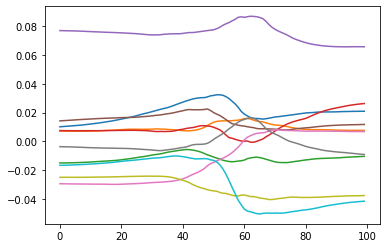

In [37]:
#1e-2
for sample in range(10):
    plt.plot(all_outputs[:, 0, sample])